In [1]:
from satpy import Scene, MultiScene
from satpy.multiscene import timeseries
from pyresample.geometry import AreaDefinition
from pathlib import Path
from itertools import chain

In [2]:
from dask.distributed import Client

client = Client(processes=False) 
client

Client Scheduler: inproc://137.248.191.131/27704/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 4 Memory: 24.85 GB


In [3]:
area_id = 'Dem. Rep. Kongo'
description = 'Dem. Rep. Kongo in Lambert Azimuthal Equal Area projection'
proj_id = 'Dem. Rep. Kongo'
proj_dict = {'proj': 'laea', 'lat_0': -3, 'lon_0': 23}
width = 500
height = 500
llx =  -15E5
lly =  -15E5
urx =  15E5
ury =  15E5
area_extent = (llx,lly,urx,ury)
area_def = AreaDefinition(area_id, proj_id, description, proj_dict, width, height, area_extent)

In [13]:
# Load all files in a given folder:
file_dir = Path("../../data/msg")
file_dir = Path("/media/droplet_data/python_course_data/exercise_7_data/")
files = file_dir.glob("*20180*1200*.nc")
#files = list(files)[0:3]
#files = chain(files, file_dir.glob("*201801*2000*.nc"))

In [14]:
from satpy.readers import group_files

#files = group_files(files, reader="seviri_l1b_nc", group_keys=["processing_time"])

In [15]:
#Create MultiScene
#scenes = [Scene(reader="seviri_l1b_nc", filenames=[f]) for f in files]
#mscn = MultiScene(scenes)
mscn = MultiScene.from_files(files, reader="seviri_l1b_nc", group_keys=["processing_time"])

In [16]:
# Load the 10.8 micrometer band of all scenes within the MultiScene
mscn.load(["IR_108", "IR_039"])#, "WV_073", "IR_120"])

# Resample the MultiScene to our Greece domain
new_mscn = mscn.resample(area_def, cache_dir=".")

# Blend the scenes to one single Scene with each dataset/channel extended by the time dimension
bscn = new_mscn.blend(blend_function=timeseries)

/home/ro/bin/miniconda3/envs/python_kurs/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


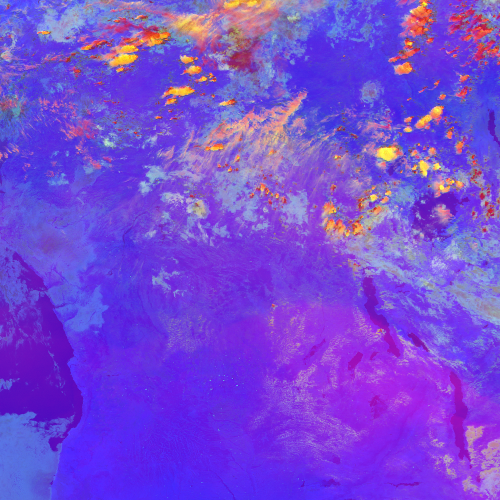

In [20]:
scn = Scene(reader="seviri_l1b_nc", filenames=[files[0]])
scn.load(["convection"])
scn = scn.resample(area_def)
scn.show("convection")

In [17]:
bscn["diff_108"] = bscn["IR_108"] - bscn["IR_039"]
bscn["diff_108"] = bscn["diff_108"].compute()
#Infrared Gross Cloud Check (Saunders and Kriebel, 1988): if 12 m m brightness temperature of a pixel is less than 279.6 K, then I label it as cloud-contaminated
#https://www.cfa.harvard.edu/~xliu/res/CloudRetrieval.htm

#midlevel clouds over land at night (modis cloud product algorithm manual)
#The thresh-olds used are -8K, -10K, and -11K for low, mid-point, and high confidences, respectively
#bscn["diff_073"] = bscn["WV_073"] - bscn["IR_108"]
#bscn["diff_073"].compute()
#cirrus clouds 11-12 um (modis cloud product algorithm manual p.28)
#threshold ca. 9

/home/ro/bin/miniconda3/envs/python_kurs/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


In [24]:
bscn["diff_108"] = bscn["diff_108"].sel(time=bscn["diff_108"].time.dt.hour == 12)

/home/ro/bin/miniconda3/envs/python_kurs/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


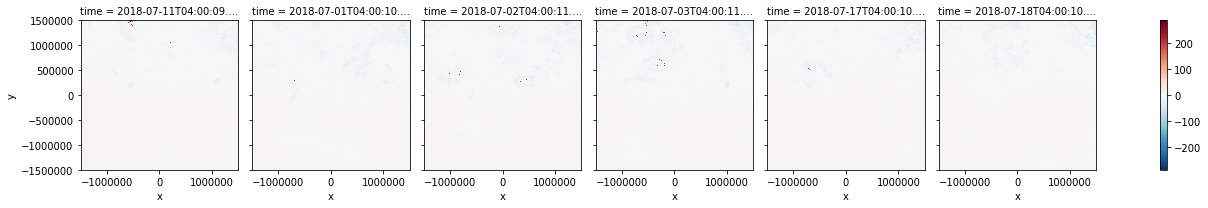

In [40]:
%matplotlib inline
bscn2["diff"].plot(x="x", y="y", col="time")

In [54]:
mask = ((bscn["diff_108"] < -20) | (bscn["diff_108"] > 5))

res = mask.groupby("time.month").mean("time").compute()

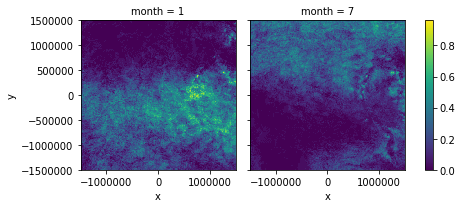

In [55]:
%matplotlib inline
res.plot(x="x", y="y", col="month")